# HW 3.2 High-dimensional data

In [1]:
import os
import pickle

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

PATH_DATA = os.path.join('data', 'hw3-q2.pkl')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
with open(PATH_DATA, 'rb') as file:
    dataset = pickle.load(file)
    
xs_train = dataset['train'][:256] # TODO
xs_val = dataset['valid'][:256] # TODO

In [3]:
batch_size = 128

def collate_fn(xs):
    xs = torch.tensor(xs, dtype=torch.float32)
    xs = xs * 2 / 255 - 1
    xs = xs.permute(0, 3, 1, 2)
    return xs

train_data_loader = data.DataLoader(
    dataset=xs_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=xs_val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

## Part A

In [4]:
class GatedShortcutConnection(nn.Module):
    def __init__(self, channels=128):
        super(GatedShortcutConnection, self).__init__()
                 
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
                 
    def forward(self, x):
        return self.conv1(x) * self.sigmoid(self.conv2(x))

In [5]:
class ResidualStack(nn.Module):
    def __init__(self, channels=64):
        super(ResidualStack, self).__init__()
                 
        layers = []
        for _ in range(5):
            layers += [
                nn.Conv2d(channels * 2, channels, kernel_size=3, padding=1, bias=False),
                nn.ReLU(),
                nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
                nn.ReLU(),
                GatedShortcutConnection(channels=channels * 2),
                nn.ReLU(),
            ]
        self.layers = nn.Sequential(*layers)
                 
    def forward(self, x):
        return self.layers(x)

In [6]:
class Encoder(nn.Module):
    def __init__(self, channels):
        super(Encoder, self).__init__()
        
        self.channels = channels
        
        layers = [
            nn.Conv2d(3, self.channels * 2, 
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 2, self.channels * 4,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 4, self.channels * 2,
                      kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            #ResidualStack(self.channels), # TODO
            nn.Conv2d(self.channels * 2, self.channels * 4,
                      kernel_size=1)
        ]
        self.layers = nn.Sequential(*layers)
                 
    def forward(self, x):
        x = self.layers(x)
        x = x.reshape(-1, 2, 2 * self.channels * 8 * 8)
        mu, log_var = x[:, 0, :], x[:, 1, :]
        var = torch.exp(log_var)
        return mu, var

In [7]:
class Decoder(nn.Module):
    def __init__(self, channels):
        super(Decoder, self).__init__()
        
        self.channels = channels
        
        layers = [
            nn.Conv2d(self.channels * 2, self.channels * 2,
                      kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            #ResidualStack(self.channels), # TODO
            nn.ConvTranspose2d(self.channels * 2, self.channels * 2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels * 2, 3,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        ]
        self.layers = nn.Sequential(*layers)
                 
    def forward(self, x):
        x = x.reshape(-1, 2 * self.channels, 8, 8)
        return self.layers(x)

In [8]:
class VAE(nn.Module):
    def __init__(self, channels=64):
        super(VAE, self).__init__()
        
        self.channels = channels
        
        self.encoder = Encoder(channels)
        self.decoder = Decoder(channels)
        
    def get_latent_size(self):
        return 2 * self.channels * 8 * 8
    
    def reparameterize(self, mu, var):
        eps = torch.randn_like(mu, device=device)
        z = mu + eps * torch.sqrt(var)
        return z
            
    def encode(self, x):
        mu, var = self.encoder(x)
        z = self.reparameterize(mu, var)
        return mu, var, z
    
    def decode(self, z):
        return self.decoder(z)
            
    def forward(self, x):
        mu, var, z = self.encode(x)
        x_recon = self.decode(z)
        return mu, var, x_recon

In [9]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()
        
    def forward(self, x, target):
        loss = ((x - target) ** 2).mean()
        return loss

In [10]:
class KLLoss(nn.Module):
    def __init__(self):
        super(KLLoss, self).__init__()
        
    def forward(self, mu, var):
        kl_div = 1.0 + torch.log(var) - mu ** 2 - var
        kl_div = -0.5 * kl_div
        loss = kl_div.mean()
        return loss

In [11]:
def train(model, criterion_mse, criterion_kl,
          optimizer, scheduler, epochs):
    losses_mse_train = []
    losses_kl_train = []
    losses_train = []
    losses_mse_val = []
    losses_kl_val = []
    losses_val = []
    for i in trange(epochs):
        losses_mse = []
        losses_kl = []
        losses = []
        model.train()
        for xs in train_data_loader:
            xs = xs.to(device)
            
            optimizer.zero_grad()

            mu, var, out = model(xs)
            
            loss_mse = criterion_mse(out, xs)
            loss_kl = criterion_kl(mu, var)
            loss = loss_mse + loss_kl

            losses_mse.append(loss_mse.item())
            losses_kl.append(loss_kl.item())
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_mse_train.append(np.array(losses_mse).mean())
        losses_kl_train.append(np.array(losses_kl).mean())
        losses_train.append(np.array(losses).mean())

        losses_mse = []
        losses_kl = []
        losses = []
        model.eval()
        with torch.no_grad():
            for xs in val_data_loader:
                xs = xs.to(device)

                mu, var, out = model(xs)

                loss_mse = criterion_mse(out, xs)
                loss_kl = criterion_kl(mu, var)
                loss = loss_mse + loss_kl

                losses_mse.append(loss_mse.item())
                losses_kl.append(loss_kl.item())
                losses.append(loss.item())

        losses_mse_val.append(np.array(losses_mse).mean())
        losses_kl_val.append(np.array(losses_kl).mean())
        losses_val.append(np.array(losses).mean())
        
        if scheduler:
            scheduler.step()

    plt.plot(range(epochs), losses_mse_train, label="train")
    plt.plot(range(epochs), losses_mse_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss mse')
    plt.legend()
    plt.show()

    plt.plot(range(epochs), losses_kl_train, label="train")
    plt.plot(range(epochs), losses_kl_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss KL')
    plt.legend()
    plt.show()

    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [17]:
def show_interpolation(model, n=5, m=10):
    sample_ids = list(range(n))
    samples_a = xs_train[sample_ids]
    samples_b = xs_train[sample_ids[-1:] + sample_ids[:-1]]
    samples_a = collate_fn(samples_a).to(device)
    samples_b = collate_fn(samples_b).to(device)
    
    images = []
    with torch.no_grad():
        for i in range(n):
            a, b = samples_a[i], samples_b[i]
            (za, _, _), (zb, _, _) = model.encode(a[None, :]), model.encode(b[None, :])
            for j in range(m):
                x = model.decode(za + (zb - za) * j / (m - 1))
                x = x.permute(0, 2, 3, 1).cpu().numpy()[0]
                images.append(x)
            
    images = np.array(images)
    images = (images + 1) / 2
    images = np.clip(images, 0, 1)
    
    f, axarr = plt.subplots(n, m)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(images):
        axarr[n - 1 - i // m, i % m].imshow(img)
        axarr[n - 1 - i // m, i % m].axis('off')
    plt.show()

In [13]:
def show_sampels(model, n=100):
    z = torch.randn([n, model.get_latent_size()]).to(device)
    
    with torch.no_grad():
        images = model.decode(z)
        images = images.permute(0, 2, 3, 1).cpu().numpy()
        
    images = (images + 1) / 2
    images = np.clip(images, 0, 1)
    
    n = int(np.ceil(np.sqrt(n)))
    f, axarr = plt.subplots(n, n)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(images):
        axarr[i // n, i % n].imshow(img)
        axarr[i // n, i % n].axis('off')
    plt.show()

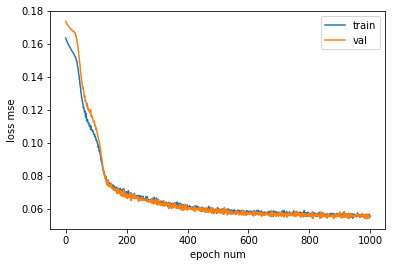

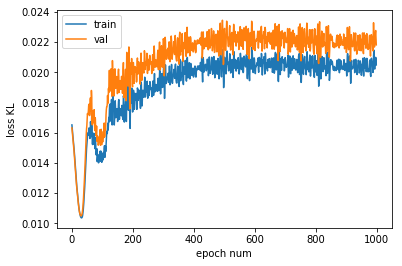

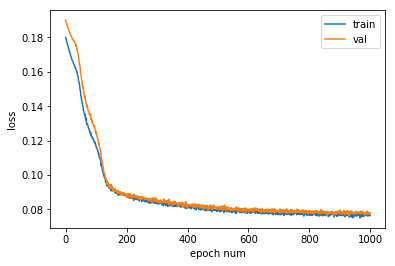

In [14]:
epochs = 1000
lr = 0.0002
w_l2 = 0

model = VAE(channels=8)
model.to(device)

criterion_mse = MSELoss()
criterion_kl = KLLoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)

train(model, criterion_mse, criterion_kl, optimizer, None, epochs)

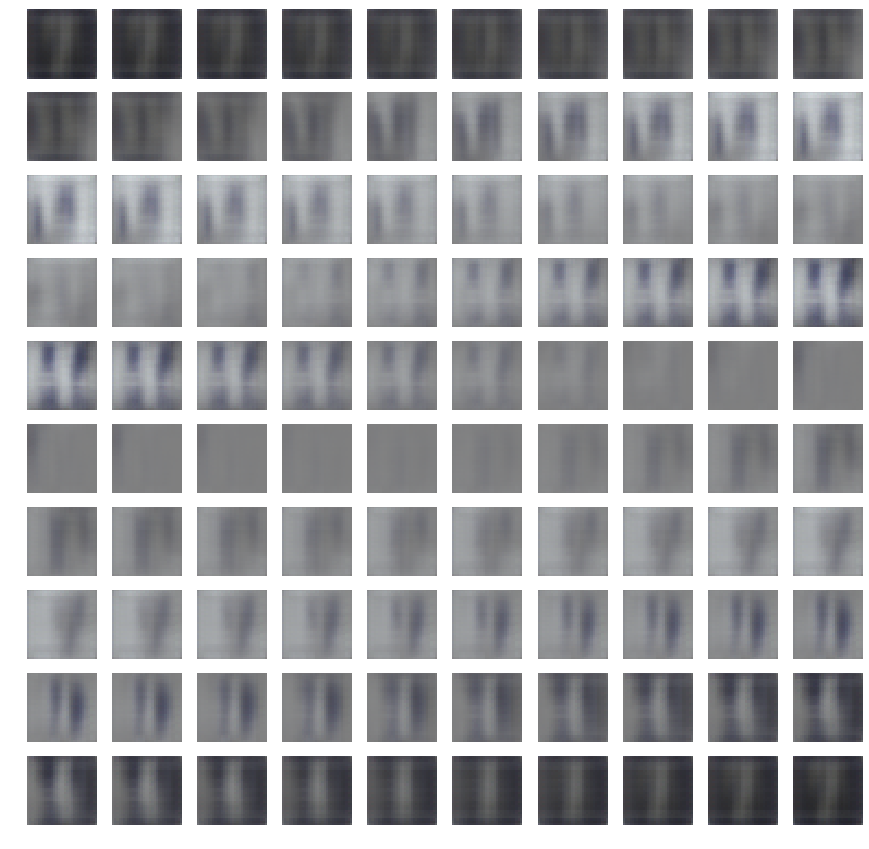

In [18]:
model.eval()
show_interpolation(model, 10, 10)

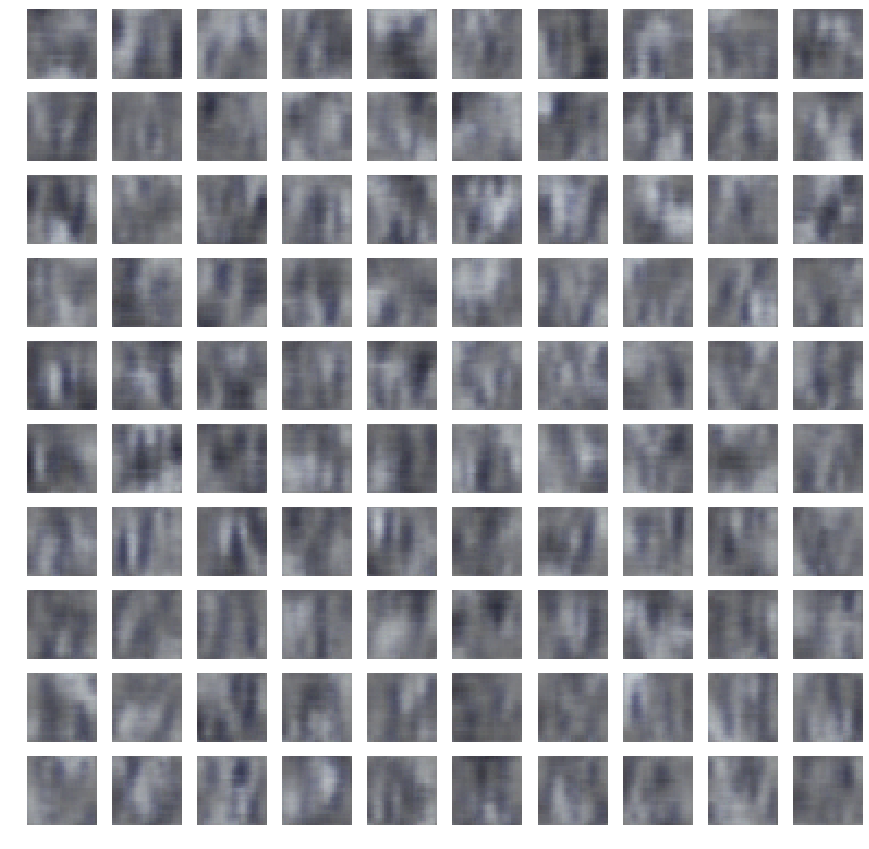

In [16]:
show_sampels(model)

## Part B